# # Project - 3 : Behavioral Cloning

## Approch 


1) Analyze the images/ Input
2) Plot the images and stats to get info about input.
3) Apply data pre-processing
4) Apply data Agumentation
5) Choose model based on data set. (Starting with 1 fully conected network to Updated Comma.ai model)
6) train the model.
7) Run it on simulator
8) based on 7, re-visit any or all of the steps and perform enhancements.

In [27]:
import os
import csv
import cv2
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pdb
import random
import sklearn
import threading

import keras
from keras.callbacks import Callback
from keras.layers import Convolution2D, Flatten, MaxPooling2D, Lambda, ELU
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential, Model
from keras.optimizers import Adam

from IPython.display import YouTubeVideo
%matplotlib inline

In [3]:
# Plot images utility
def plot_images(imgs, labels, rows=1, cols=3):
    """ 
    Plot images in rowXcol format.
    imgs: list of images to display.
    lables: Lables for the images to display
    """
    display_imgs = imgs
    display_labels = labels
    fig, axis = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 20))
    axis = axis.ravel()
    for index in range(len(display_imgs)):
        img = display_imgs[index]
        if display_imgs[index].shape[2] == 1:
            img = np.squeeze(img, axis=(2,))

        axis[index].imshow(img)
        axis[index].set_title(display_labels[index], fontsize=20)
    plt.tight_layout()

In [4]:
# Read 3 input images and display stats.

pd.set_option('expand_frame_repr', True)
# All training/input samples appended here using separate python script.
driving_log_file = "../data/driving_log.csv"
base_dir, _ = driving_log_file.rsplit("/", 1)

in_headers = ["center", "left", "right", "steering", "throttle", "brake", "speed"]

drive_log = pd.read_csv(driving_log_file, skiprows=1, header=None, names=in_headers, delimiter=' *, *', engine='python')
print("Input shape:", drive_log.shape)
print("Data stats: \n", drive_log.describe())


Input shape: (16050, 7)
Data stats: 
            steering      throttle         brake         speed
count  16050.000000  16050.000000  16050.000000  1.605000e+04
mean      -0.000208      0.746973      0.003663  2.481072e+01
std        0.236136      0.411769      0.047049  8.695510e+00
min       -1.000000      0.000000      0.000000  6.625969e-07
25%        0.000000      0.543630      0.000000  1.798305e+01
50%        0.000000      0.985533      0.000000  3.018600e+01
75%        0.000000      1.000000      0.000000  3.018671e+01
max        1.000000      1.000000      1.000000  3.070936e+01


Steering angle: 0.0
Image shape: (160, 320, 3)


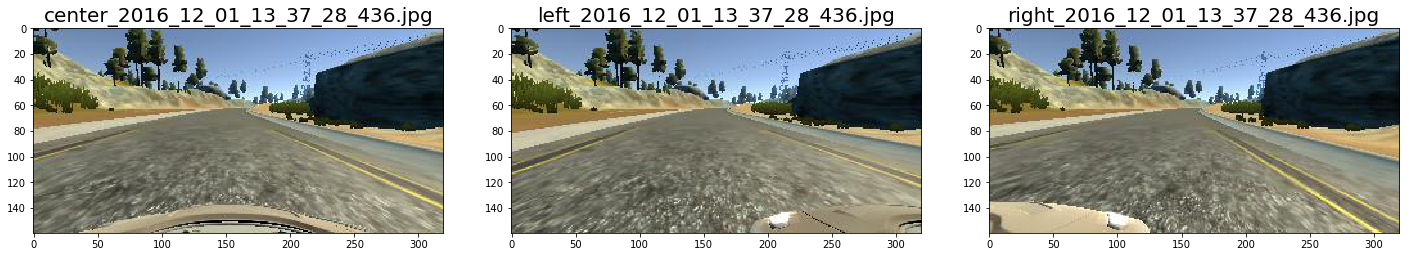

In [5]:
def read_img(rel_path):
    """
    Adds path as needed for this application and returns image in RGB format.
    """
    path = rel_path.strip()
    path = os.path.join(base_dir, path)
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    return img
    
# Display Input images for a data row frame.
f = drive_log.sample()
angle = float(f.values[0][3])
print("Steering angle:", angle)
        
labels = [f.values[0][0], f.values[0][1], f.values[0][2]]
images = [read_img(x) for x in labels]
print_labels = [x.split("/")[-1] for x in labels]

print("Image shape:", images[2].shape)
plot_images(images, print_labels)

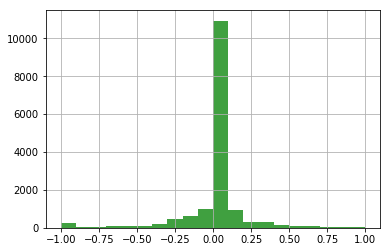

In [6]:
# Histogram of input images and steering angles.
bin_size = .1 
plt.hist(drive_log.steering, bins=np.arange(
        min(drive_log.steering), max(drive_log.steering) + bin_size, bin_size),
        facecolor='green', alpha=0.75)
plt.grid(True)
plt.show()

From above, 0.0 steering angle is way more images compared with other angles. Training has potential problem of being biased.
2 Solutions:
1.a) Data agumentation (https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html).
1.b) collecting more data (Having more tracks of recorded data).
2) Reduce Zero steering during training.

In [7]:
# Globals
EPOCHS = 10
BATCH_SIZE = 256

"""
The simulator has left and right images taken from cameras along with center camera.
Steering are for center camera, so this value is used as a factor in
calculating for left and right images.
"""
CAMERA_OFFSET = 0.25
IMG_SHAPE = None

# At what % do we keep low angles for each batch; This value gets updated in epoch end.
LOW_ANGLE_THRESHOLD = .9 
# Factor to use right and left camera angles.
MAX_DATA_AGUMENT_FACTOR =  0.5 
MIN_ANGLE = 0.1

# Maximum roation of the image.
MAX_ROTATION = 45 
# Rough numbers based on 160X320 image.
MAX_WIDTH_TRANSLATE = 100
MAX_HEIGHT_TRANSLATE = 10

# Angle counts encountered during batch.
POS_ANGLE_CNT = 0
NEG_ANGLE_CNT = 0

# Right or left camera bias.
BIAS = 0.5 # Treat left and right camera images equal initially.

## Transformation

Methods for transforming image.
This is important so trained network could be adapted for different forms.
Makes the model drive on other tracks as well.

Following transformations will be randomly applied to any input image.
a) Flip image vertically. 
b) Update brightness.
Width shift
b) Height shift
c) Zoom
e) Image brightness and contrast

In [8]:
# Transformation methods.
def flip_horizantal(img, steering):
    """ Returns a flipped image along y-axis and corrosponding steering measure. """
    
    n_img = cv2.flip(img, 1)
    n_steering = -1 * steering
    return n_img, n_steering
    
def update_brightness(img):
    """ Returns a image with randomly updated brightness. """
    
    random_factor = 0.25
    n_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    fac = np.random.uniform()
    if fac < random_factor:
        fac += random_factor
    n_img[:,:,2] = n_img[:,:,2] * fac
        
    img = cv2.cvtColor(n_img, cv2.COLOR_HSV2RGB)
    return img

def add_shadow(img):
    """ Adds shadow only to a portion to all of image size."""
    
    # Add gray overlay on top of image so the view is darkened.
    # This is to address overall shadow or dark areas like tunnels.
    # ref: http://www.pyimagesearch.com/2016/03/07/transparent-overlays-with-opencv/
    alpha = 0.75
    output = img.copy()
    img_orig = img.copy()
    alpha = np.random.uniform(high=alpha)
    overlay = cv2.rectangle(img_orig, (0, 0), (img.shape[1], img.shape[0]), (128, 128, 128), -1)
    cv2.addWeighted(overlay, alpha, output, 1 - alpha,
                    0, output)
    return output

def crop_image(img, rem_height=None, rem_width=None):
    """ Crops the image """

    n_img = None
    shape = img.shape
    if rem_height and rem_width:
        n_img = img[rem_height:rem_width, 0:shape[1]]
    else:
        # Crop random height and remove hood (25 pixels). 
        rand_h = 0.35 
        w_pixels = 25
        n_img = img[math.floor(shape[0]*rand_h): shape[0]-w_pixels, 0:shape[1]]
    return n_img

def resize_image(img, height=64, width=64):
    """ Resizes the image height and width."""
    
    return cv2.resize(img, (height, width), interpolation=cv2.INTER_AREA)

# This has to be done prior to any transform. As it relies on center camera.
# TODO: Needs more updates - Rotating a right tilt image to left or Viceversa
# migth cause problems. Removed from final model training.
def rotate_image(img, steering, max_angle=MAX_ROTATION):
    """Rotate an image by a factor between 0 and max at center of image."""
    image_center = tuple(np.array(img.shape)/2)
    rot_factor = np.random.randint(max_angle)
    
    rot_mat = cv2.getRotationMatrix2D(image_center,rot_factor, 1)
    rot_img = cv2.warpAffine(image, rot_mat, img.shape, flags=cv2.INTER_LINEAR)
    # Add X-axis change to actual steering.
    rot_angle = steering + math.cos(math.radients(rot_factor))
    
    return r_img, rot_angle

def translate_image(img, steering, height_translate=MAX_HEIGHT_TRANSLATE, width_translate=MAX_WIDTH_TRANSLATE):
    """
    Shifts the image by a random factor upto max height and width.
    Returns new image and steering.
    """

    rows, cols, _ = img.shape        
    trans_x = width_translate * np.random.uniform() - width_translate / 2
    trans_y = height_translate * np.random.uniform() - height_translate / 2
    trans = np.float32([[1, 0, trans_x],
                        [0, 1, trans_y]])
     
    t_img = cv2.warpAffine(img, trans, (cols, rows))
    t_steering = steering + trans_x / width_translate * 2 * CAMERA_OFFSET
    return t_img, t_steering

# When lanes dont exist on plain fields the car cant differenciate between lane and land/field.
# Removed from final training.
def grayscale_image(img):
    """Convert image to gray scale by average method."""
    return np.sum(img/3, axis=2, keepdims=True)
    

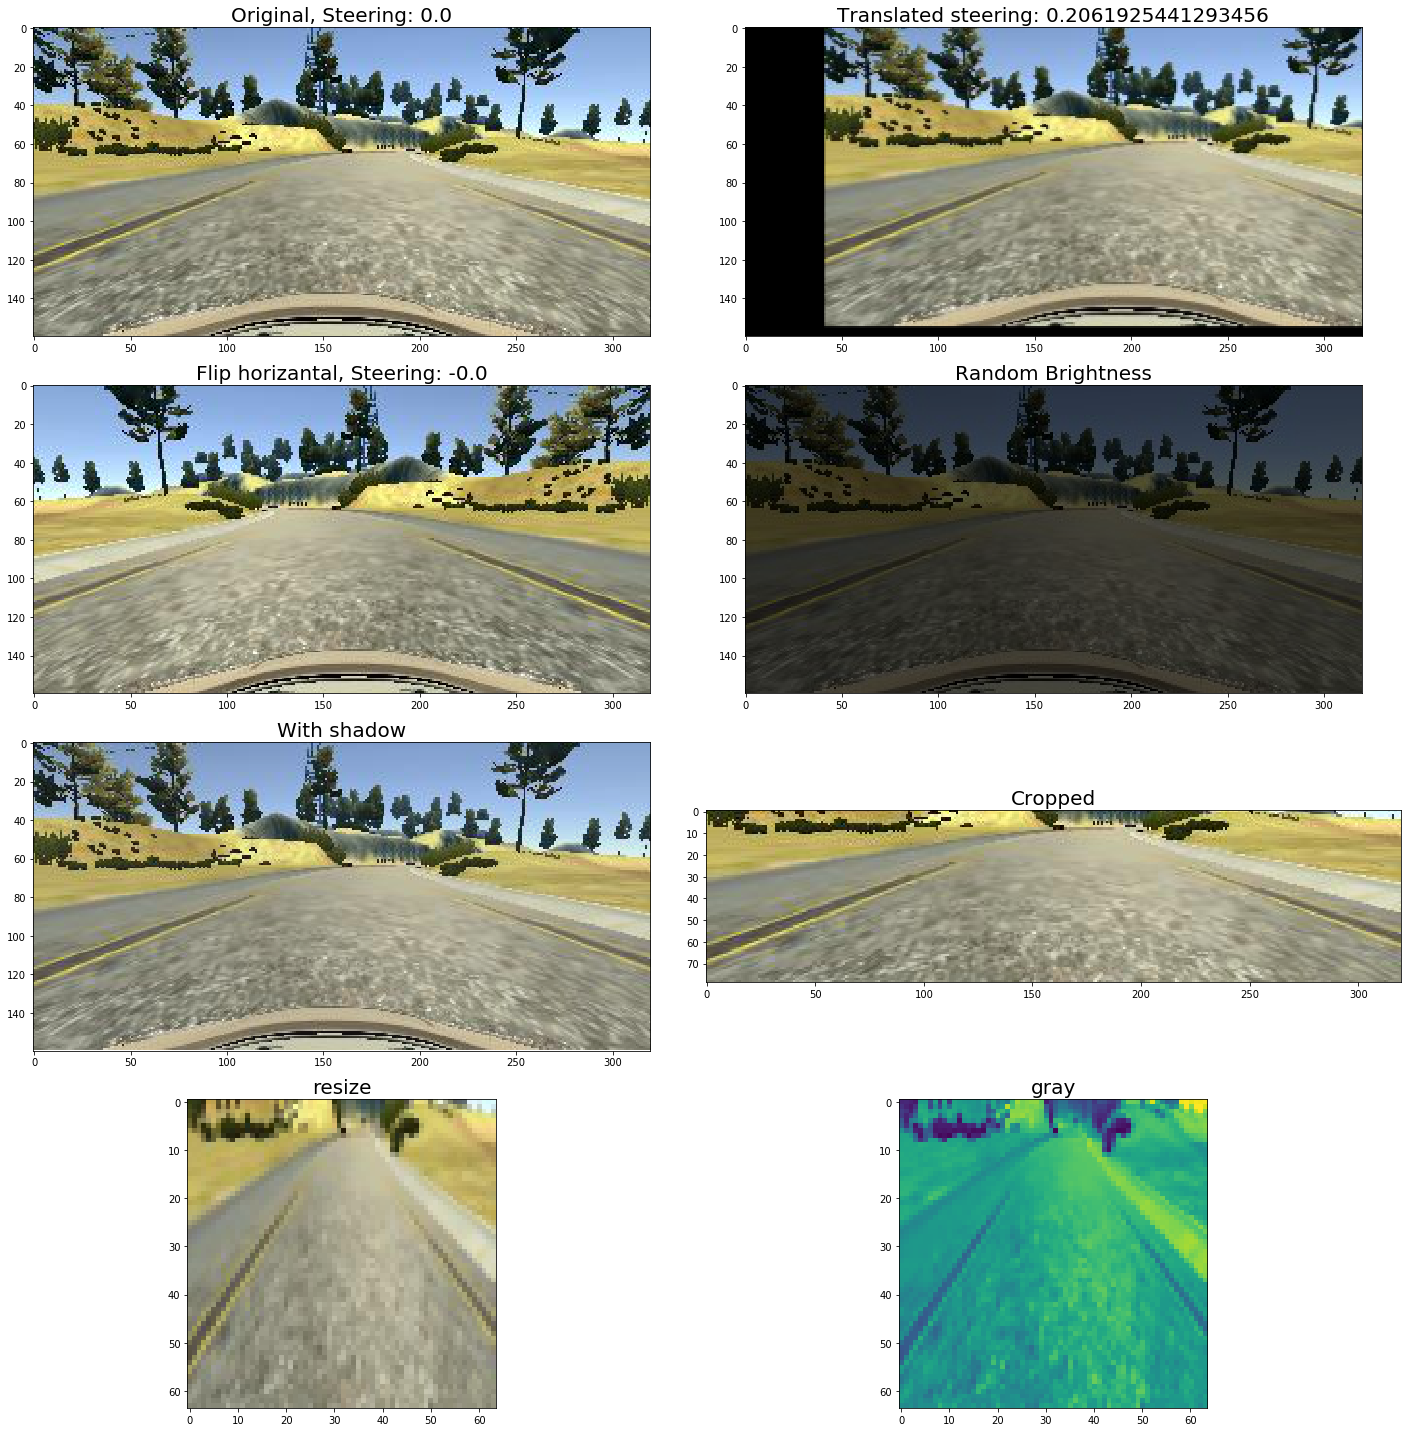

In [9]:
# Test all Transformations

images = []
labels = []
num_samples = 1
for i in range(num_samples):
    # Get random log index.
    f = drive_log.sample()
    # Take center image.
    img_path = f.values[0][0]
    steering = str(f.values[0][3])

    orig = read_img(img_path)
    images.append(orig)
    labels.append("Original, Steering: {0}".format(steering))
    
    # Translate
    fp, fp_steering = translate_image(orig, float(steering))
    images.append(fp)
    labels.append("Translated steering: {0}".format(fp_steering))
    
    # Flip
    fp, fp_steering = flip_horizantal(orig, float(steering))
    images.append(fp)
    labels.append("Flip horizantal, Steering: {0}".format(fp_steering))
    
    # brightness
    images.append(update_brightness(orig))
    labels.append("Random Brightness")
    
    # Add shadow
    images.append(add_shadow(orig))
    labels.append("With shadow")
    
    # crop
    crop_img = crop_image(orig)
    images.append(crop_img)
    labels.append("Cropped")
    
    # Resize
    resize_img = resize_image(crop_img)
    images.append(resize_img)
    labels.append("resize")
    
    # Grayscale
    gray_img = grayscale_image(resize_img)
    images.append(gray_img)
    labels.append("gray")
    
plot_images(images, labels, rows=num_samples * 4, cols=2)

In [10]:
# Apply random transformations.

def random_transform(img, steering):
    """
    Given an input image it applies random transform.
    1) Translate width and height (Apply 70% of time.)
    2) Apply shadow and brightness (33% of time original, 33% shadow 33% brightness.)
    3) 50% of time apply horizantal flip.
    4) 100% cropped
    5) 100% resize.
    """
    t_img = None
    t_steering = steering
    t_img = img
    
    # a
    #img, steering = rotate_image(img, steering)
    
    # a.1
    if np.random.uniform() < 0.7:
        img, steering = translate_image(img, steering)
    
    # a
    factor = np.random.randint(3)
    if factor == 1:
        t_img = add_shadow(img)
    elif factor == 2:
        t_img = update_brightness(img)
    else:
        t_img = img
        
    # b
    factor = np.random.uniform()
    if factor < 0.5:
        t_img, t_steering = flip_horizantal(t_img, steering)
    
    # c
    t_img = crop_image(t_img)
    
    #d Will result in 64*64*3 by default.
    t_img = resize_image(t_img)
    
    # Convert to grayscale
    # TODO: Failing on flat surfaces and goes straight. hmm?
    # t_img = grayscale_image(t_img)
    
    return t_img, t_steering


In [11]:
# Data agumentation

# Data agumentation is needed and in this case based on input steering histogram,
# we either need more data or use exisitng. Given left and right steering it could
# utilized. Since images and angles already exist we now have more data with varying angles.

def data_agument(line_log):
    """Utilize existing images from left and right camera here.
    The data we are agumenting here is the steering angles.
    """
    file_path = None
    steering_fac = 0
    new_img = None
    steering = float(line_log[4])
    
    # Agument data only for low angles or angles obtained for using different cameras.
    if abs(steering) <= MIN_ANGLE:
        # Use left and right camera based on the DATA_AGUMENT_FACTOR.
        agument_factor = np.random.uniform()
        left = MAX_DATA_AGUMENT_FACTOR * BIAS
        # Get left camera image
        if agument_factor <= left :
            file_path = line_log[2]
            steering_fac = CAMERA_OFFSET
        # Get right camera image
        elif agument_factor > left and agument_factor <= MAX_DATA_AGUMENT_FACTOR:
            file_path = line_log[3]
            steering_fac = -CAMERA_OFFSET
        else: # Use center camera.
            file_path = line_log[1]
            steering_fac = 0
    else: # Use center camera.
        file_path = line_log[1]
        steering_fac = 0
    
    new_img = read_img(file_path)
    new_steering = steering + steering_fac
    return new_img, new_steering

def image_agument_and_preprocess(line_log):
    """Aguments the data and applies transformation."""
    
    img, steering = data_agument(line_log)
    img, steering = random_transform(img, steering)
    global IMG_SHAPE
    if not IMG_SHAPE:
        IMG_SHAPE = img.shape
    return img, steering

Training set: 14445
Validation set: 1605


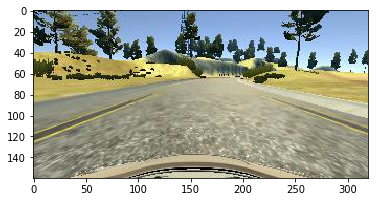

In [12]:
# Slice data for training and validation.
def slice_training_data(drive_log):
    # Shuffle data.
    data = sklearn.utils.shuffle(drive_log)
    # give 90% of data for training and 10 for validation.
    num_train = int(len(data) * 0.90)
    X_train = data.iloc[:num_train]
    X_validation = data.iloc[num_train:]
    return X_train, X_validation

X_train, X_validation = slice_training_data(drive_log)
print("Training set: {}".format(len(X_train)))
print("Validation set: {}".format(len(X_validation)))

s = X_train.sample()
p = s.values[0][0]
img = read_img(img_path)
plt.imshow(img)

In [13]:
# For analyzing how steering angles are used in training.
gen_angles = []
# Get data for epoch.
def samples_per_epoch(array_size):
    """Calculates samples per epoch based on array_size.
    Uses global variable BATCH_SiZE
    """
    # samples_per_epoch = batch_size * number_of_batches
    # It should be a number evenly divided by BATHSIZE.
    
    num_batches_epoch = math.ceil(array_size/BATCH_SIZE)
    return (num_batches_epoch * BATCH_SIZE) + BATCH_SIZE


def get_image_shape(samples):
    """ Returns the image shape. Assumes all the images
    are of same shape.
    """
    f = samples.sample()
    img_path = f.values[0][0]
    img = read_img(img_path)
    img, _ = random_transform(img, 0.0)
    return img.shape
    
def generate_samples(samples, batch_size=32):
    """ Generates samples from the input for epoches for keras generator. """
    
    global IMG_SHAPE
    if IMG_SHAPE is None:
        IMG_SHAPE = get_image_shape(samples)
        
    num_samples = len(samples)
    while True:
        sklearn.utils.shuffle(samples)
        low_angle_count = 0
        for offset in range(0, num_samples, batch_size):
            global POS_ANGLE_CNT
            global NEG_ANGLE_CNT
            POS_ANGLE_CNT = 0
            NEG_ANGLE_CNT = 0
            sample_images = []
            sample_angles = []
            batch_samples = samples.iloc[offset:offset+batch_size, :].reset_index()
            for index, bsample in batch_samples.iterrows():    
                line_log = bsample.values
                image, angle = image_agument_and_preprocess(line_log)
                
                # Attempt to get bellcurve; 
                while abs(angle) <= MIN_ANGLE or abs(angle) == CAMERA_OFFSET: 
                    # Break it depending on threshold. ex: 0.9, 0.5(1/1+epoch_1), 0.25 so forth.
                    if np.random.uniform() > LOW_ANGLE_THRESHOLD: 
                        break
                    else:
                        image, angle = image_agument_and_preprocess(bsample.values)

                # To help generage bias factor in batch end event.
                if angle > 0:
                    POS_ANGLE_CNT += 1
                elif angle < 0:
                    NEG_ANGLE_CNT += 1
                    
                sample_images.append(image)
                sample_angles.append(angle)
                gen_angles.append(angle)
            
            sample_images = np.array(sample_images)
            sample_angles = np.array(sample_angles)
            yield sample_images, sample_angles

Image Shape (9, 64, 64, 3)


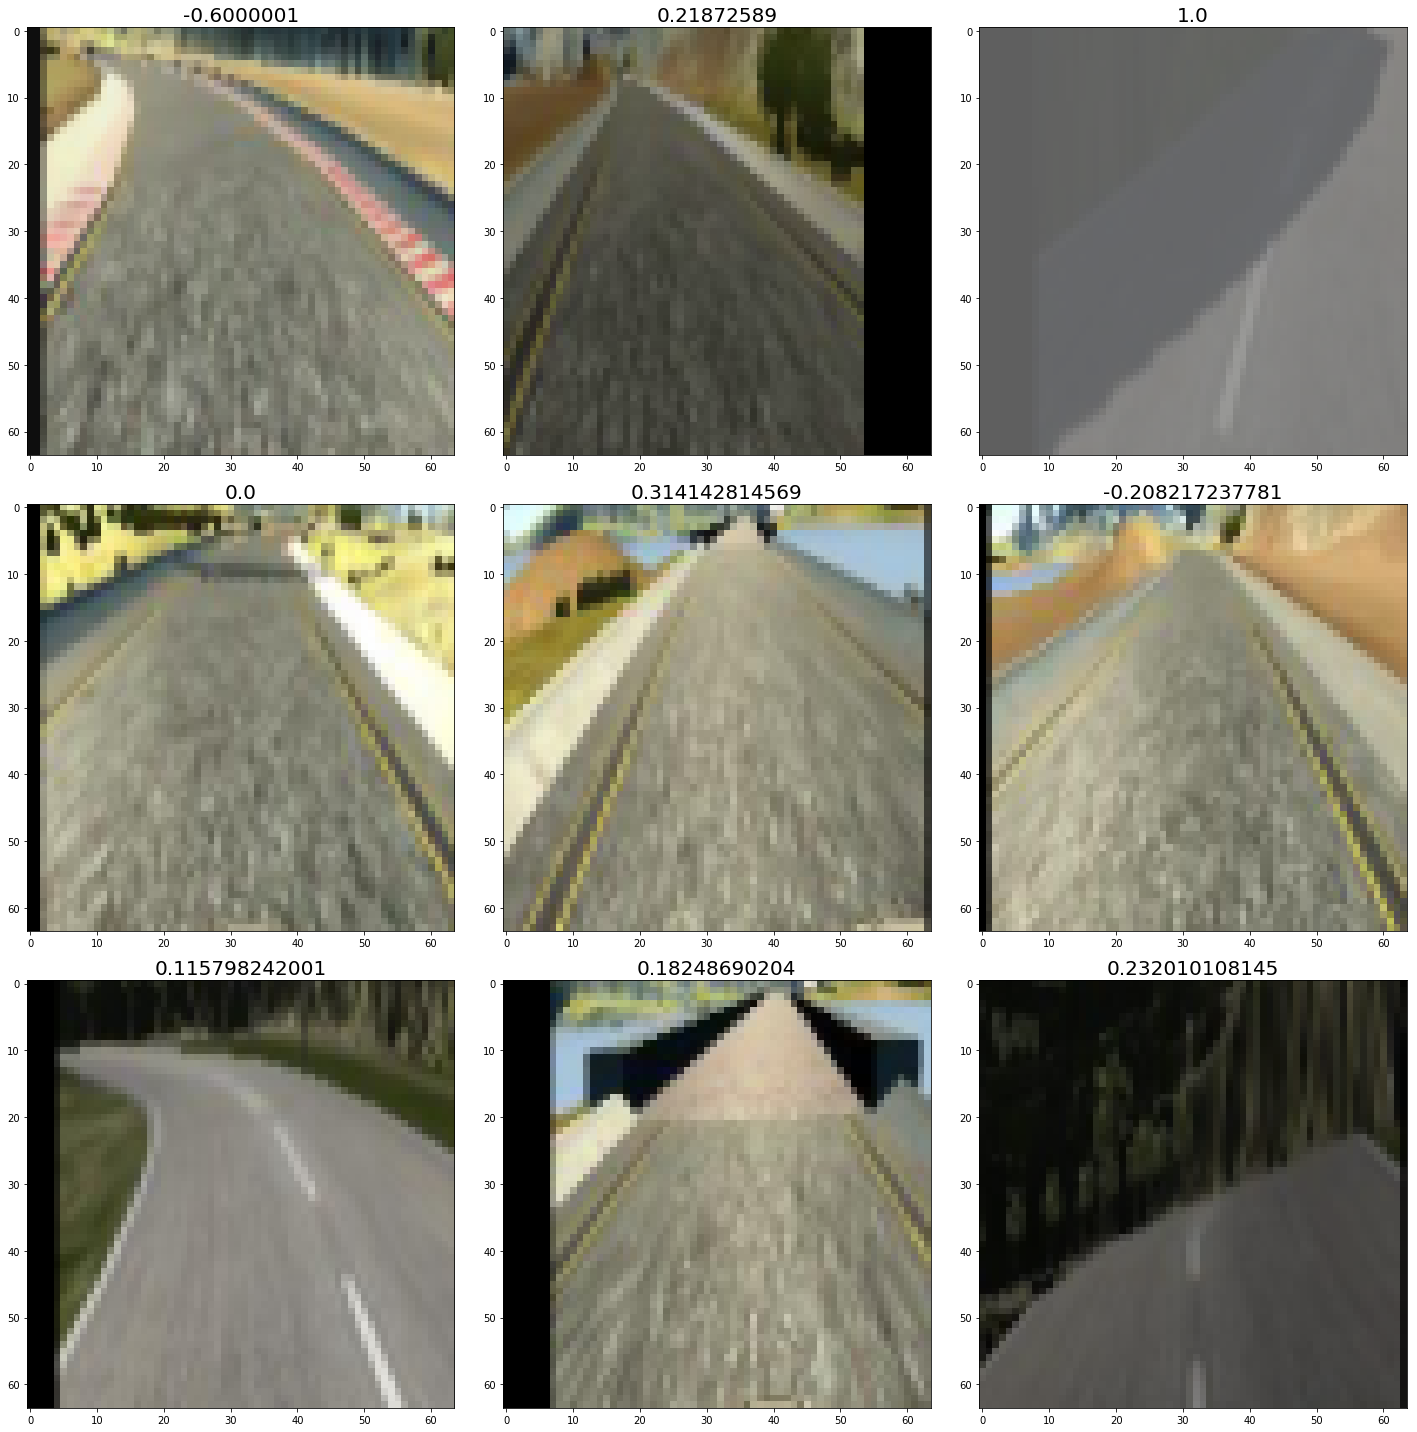

In [14]:
# View data from generator.
it = generate_samples(X_train, batch_size=9)
sample_images, sample_steerings = it.__next__()
print("Image Shape", sample_images.shape)
plot_images(sample_images, sample_steerings, rows=3, cols=3)

In [15]:
# Go over all samples and get samples 

comma.ai model
ref: https://github.com/commaai/research/blob/master/train_steering_model.py

In [16]:
# Original comma.ai model ref: https://github.com/commaai/research/blob/master/train_steering_model.py
# Model below is updated comma.ai model with MaxPool2D for addressing overfitting during convolutions training
# and added one more fully-connected layer for fine tuning.
def model():
    """ Modified version of Comma.ai model implementation."""
  
    row, col, ch = IMG_SHAPE

    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,
            input_shape=(row, col, ch),
            output_shape=(row, col, ch)))
    model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same", activation='elu', name='conv_1'))
    model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same",activation='elu', name='conv_2'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=None, border_mode='valid'))
    model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same", activation='elu', name='conv_3'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=None, border_mode='valid'))
    model.add(Flatten())
    model.add(Dropout(.2))
    model.add(ELU())
    model.add(Dense(512, activation='elu', name='fc1'))
    model.add(Dropout(.2))
    model.add(ELU())
    model.add(Dense(256, activation='elu', name='fc2'))
    model.add(Dropout(.5))
    model.add(ELU())
    model.add(Dense(1, name="final_output"))

    model.summary()
    opt = Adam(lr=0.0001)
    model.compile(optimizer=opt, loss="mse", metrics=[])

    return model

## Print model.


In [17]:
# Mostly for logging and debug

class Logging_Callback(keras.callbacks.Callback):

    def on_epoch_begin(self, epoch, logs={}):
        
        pass

    def on_epoch_end(self, epoch, logs={}):
        global LOW_ANGLE_THRESHOLD
        LOW_ANGLE_THRESHOLD = 1/(1+epoch)
        pass

    def on_batch_begin(self, batch, logs={}):
        pass

    def on_batch_end(self, batch, logs={}):
        """ For every batch maintain pos and neg angles equal
        based on previous valus.
        """
        global POS_ANGLE_CNT
        global NEG_ANGLE_CNT
        global BIAS
        if NEG_ANGLE_CNT + POS_ANGLE_CNT != 0:
            current_bias = NEG_ANGLE_CNT / (NEG_ANGLE_CNT + POS_ANGLE_CNT)
            BIAS = (1 - current_bias)
        else:
            BIAS = 0.5
        self.losses.append(logs.get("loss"))

    def on_train_begin(self, logs={}):
        print("Training Begin")
        self.losses = []

    def on_train_end(self, logs={}):
        print("Training End")

In [18]:
log_callback = Logging_Callback()       
model = model()
train_generator = generate_samples(X_train, BATCH_SIZE)
validation_generator = generate_samples(X_validation, BATCH_SIZE)

# Samples per epoch is batch_size * items_per_batch; 
# Unique samples.

train_samples = samples_per_epoch(len(X_train)*IMG_SHAPE[2])
validation_samples = samples_per_epoch(len(X_validation)*IMG_SHAPE[2])

history = model.fit_generator(train_generator, 
                              validation_data = validation_generator,
                              samples_per_epoch = train_samples, 
                              nb_val_samples = validation_samples,
                              nb_epoch = EPOCHS, verbose=1,
                              callbacks=[log_callback])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 64, 64, 3)     0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
conv_1 (Convolution2D)           (None, 16, 16, 16)    3088        lambda_1[0][0]                   
____________________________________________________________________________________________________
conv_2 (Convolution2D)           (None, 8, 8, 32)      12832       conv_1[0][0]                     
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 4, 4, 32)      0           conv_2[0][0]                     
___________________________________________________________________________________________

/Users/mm/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


43847/43776 [==============================] - 320s - loss: 0.0830 - val_loss: 0.0719
Epoch 2/10
43847/43776 [==============================] - 373s - loss: 0.0703 - val_loss: 0.0654

In [19]:
print("Saving model..")
model.save("./model.h5")
print("Saved model to disk")
del model

Saving model..
Saved model to disk


Keras Version: 1.2.1


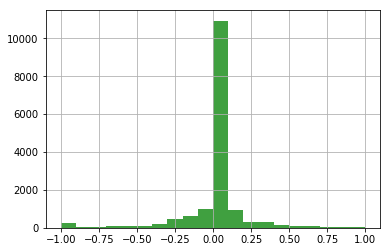

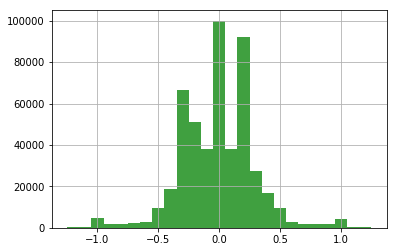

In [23]:
print("Keras Version:", keras.__version__)
# Histogram of input images and steering angles.

# Original
bin_size = .1
plt.hist(drive_log.steering, bins=np.arange(
        min(drive_log.steering), max(drive_log.steering) + bin_size, bin_size),
        facecolor='green', alpha=0.75)
plt.grid(True)
plt.show()

# Post Training
plt.hist(gen_angles, bins=np.arange(
        min(gen_angles), max(gen_angles) + bin_size, bin_size),
        facecolor='green', alpha=0.75)
plt.grid(True)
plt.show()

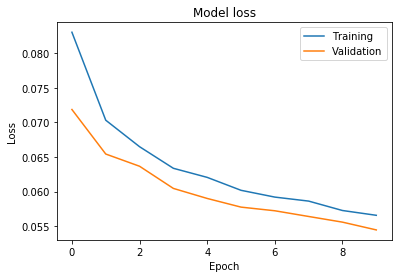

In [32]:
# Analyze loss.
# Plot loss for epoches.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()

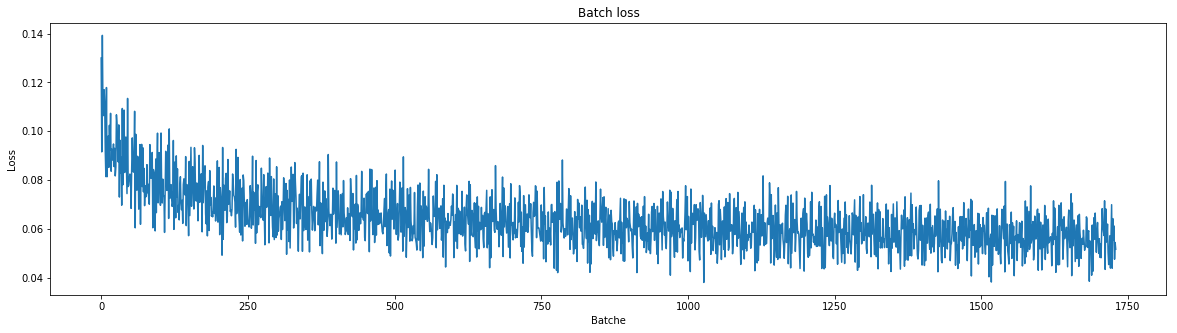

In [25]:
plt.figure(figsize=(20, 5))
plt.plot(log_callback.losses)
plt.title('Batch loss')
plt.xlabel('Batche')
plt.ylabel('Loss')
plt.show()

## Testing
Track 1 was successful without hitting sidelines. Can drive upto 25 MPH with lower MPH being more stable.
Track 2 was partly successful with driving only less than half way through and in low MPH (9 MPH). Approx 3000 images of track2 were trained which is way low than what is given for Track 1 (~11K).

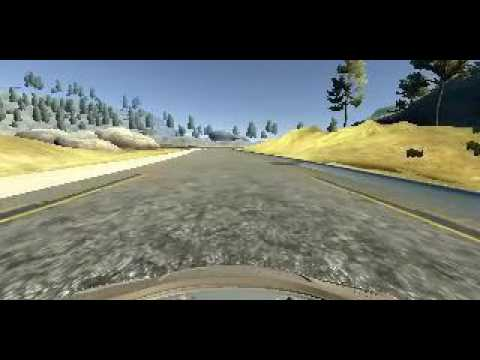

In [29]:
# uploaded under murali.madala@gmail.com.
YouTubeVideo('2vhMaozvGAE')


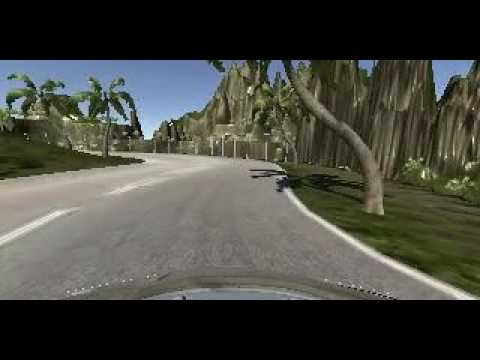

In [30]:
YouTubeVideo('JI0QBOm47Zs')